In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

# Function Definitions

## Time Delay Neural Network

In [2]:
def construct_tdnn_data(X, t=2):
    data = []
    input_i = [0 for _ in range(t)]
    for x in X:
        input_i.pop(0)
        input_i.append(x)
        
        data.append(torch.Tensor(input_i))
        
    return torch.stack(data)

In [3]:
def evaluate(model, dl_valid, loss_fn):
    model.eval()
    
    valid_loss = 0.0
    n = 0
    
    for x, y in dl_valid:
        y_pred = model(x)
        loss = loss_fn(y_pred.view(-1), y)
        valid_loss += loss.item()
        n += 1
        
    return valid_loss / n

In [4]:
def train(X_train, y_train, X_valid, y_valid, window_size, hidden_dim, learning_rate, num_epochs):
    X_train = construct_tdnn_data(X_train, window_size)
    y_train = torch.Tensor(y_train)
    
    X_valid = construct_tdnn_data(X_valid, window_size)
    y_valid = torch.Tensor(y_valid)

    ds_train = torch.utils.data.TensorDataset(X_train, y_train)
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=64)

    ds_valid = torch.utils.data.TensorDataset(X_valid, y_valid)
    dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=64)

    model = nn.Sequential(
        nn.Linear(window_size, hidden_dim),
        nn.Tanh(),
        nn.Linear(hidden_dim, 1)
    )

    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    loss_fn = torch.nn.MSELoss(reduction="mean")

    train_losses = []
    valid_losses = []

    for i in tqdm(range(num_epochs)):

        valid_loss = 0.0
        train_loss = 0.0
        n = 0
        model.train()

        for x, y in dl_train:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred.view(-1), y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            n += 1

        train_loss /= n
        train_losses.append(train_loss)
        valid_losses.append(evaluate(model, dl_valid, loss_fn))
    
    return train_losses, valid_losses

In [5]:
import itertools

def grid_search(grid, X_train, y_train, X_valid, y_valid):
    
    best_loss = np.inf
    best_params = None
    best_train_losses = None
    best_valid_losses = None
    
    for (window_size, hidden_dim, learning_rate, num_epochs) in itertools.product(*grid.values()):
        
        train_losses, valid_losses = train(X_train, y_train, X_valid, y_valid, window_size, hidden_dim, learning_rate, num_epochs)
        
        if valid_losses[-1] < best_loss:
            best_loss = valid_losses[-1]
            best_params = (window_size, hidden_dim, learning_rate, num_epochs)
            best_train_losses = train_losses
            best_valid_losses = valid_losses

        print(" -- finished", (window_size, hidden_dim, learning_rate, num_epochs), "loss", valid_losses[-1])
            
    print("finished grid search, the best are:", best_params)
        
    return best_train_losses, best_valid_losses, best_params

## RNN

In [6]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, act_fn='tanh'):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, nonlinearity=act_fn)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, h0):
        out, hn = self.rnn(x, h0)
        out = self.fc(out)
        return out, hn

In [7]:
def evaluate_rnn(model, X_valid, y_valid, hidden_state, loss_fn):
    model.eval()
    
    valid_loss = 0.0
    
    y_pred, hidden_state = model(X_valid, hidden_state)
    loss = loss_fn(y_pred.view(-1), y_valid)

    return loss.item()

In [27]:
def train_rnn(X_train, y_train, X_valid, y_valid, hidden_dim, learning_rate, num_epochs):
    X_train = torch.Tensor(X_train).reshape((X_train.shape[0], 1, 1))
    y_train = torch.Tensor(y_train).reshape((y_train.shape[0], 1, 1))
    
    X_valid = torch.Tensor(X_valid).reshape((X_valid.shape[0], 1, 1))
    y_valid = torch.Tensor(y_valid).reshape((y_valid.shape[0], 1, 1))

    model = RNNModel(1, hidden_dim, 1, 1)

    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    loss_fn = torch.nn.MSELoss(reduction="mean")

    train_losses = []
    valid_losses = []

    for i in tqdm(range(num_epochs)):

        valid_loss = 0.0
        train_loss = 0.0
        model.train()

        hidden_state = torch.zeros(1, 1, hidden_dim)

        optimizer.zero_grad()
        y_pred, hidden_state = model(X_train, hidden_state)
        loss = loss_fn(y_pred.view(-1), y_train.view(-1))
        loss.backward()
        optimizer.step()
        hidden_state = hidden_state.detach()

        train_loss += loss.item()

        train_losses.append(train_loss)
        valid_losses.append(evaluate_rnn(model, X_valid, y_valid, hidden_state, loss_fn))
    
    return train_losses, valid_losses

In [9]:
def grid_search_rnn(grid, X_train, y_train, X_valid, y_valid):
    
    best_loss = np.inf
    best_params = None
    best_train_losses = None
    best_valid_losses = None
    
    for (hidden_dim, learning_rate, num_epochs) in itertools.product(*grid.values()):
        
        train_losses, valid_losses = train_rnn(X_train, y_train, X_valid, y_valid, hidden_dim, learning_rate, num_epochs)
        
        if valid_losses[-1] < best_loss:
            best_loss = valid_losses[-1]
            best_params = (hidden_dim, learning_rate, num_epochs)
            best_train_losses = train_losses
            best_valid_losses = valid_losses

        print(" -- finished", (hidden_dim, learning_rate, num_epochs), "loss", valid_losses[-1])
            
    print("finished grid search, the best are:", (hidden_dim, learning_rate, num_epochs))
    
    return best_train_losses, best_valid_losses, (hidden_dim, learning_rate, num_epochs)

In [ ]:
def predict_rnn(model, X):
    return model(X)

# NARMA10

In [10]:
data_narma10 = pd.read_csv("data/NARMA10.csv", header=None)

In [11]:
data_narma10.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,...,0.08209,0.19951,0.26618,0.43761,0.32952,0.39381,0.063013,0.26249,0.44974,0.054542
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.26495,0.21299,0.26849,0.19633,0.32609,0.31816,0.448240,0.26351,0.20217,0.365350


In [12]:
X = data_narma10.loc[1, :].to_numpy()
y = data_narma10.loc[0, :].to_numpy()

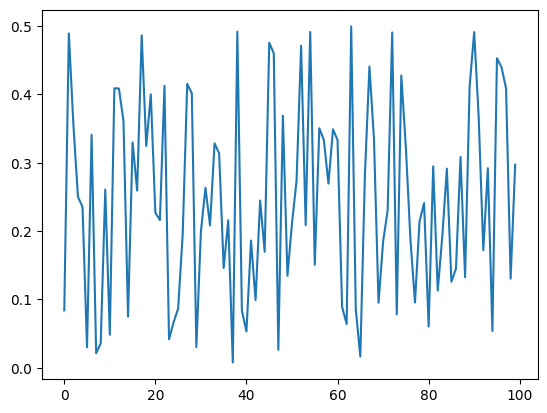

In [13]:
plt.plot(y[:100])
plt.show()

## TDNN

In [14]:
# train split
X_train = X[:4000]
y_train = y[:4000]

# valid split
X_valid = X[4000:5000]
y_valid = y[4000:5000]

In [15]:
grid = {
    "window_size" : [2, 5],
    "hidden_dim" : [30, 50],
    "learning_rate" : [0.01, 0.1],
    "num_epochs" : [100]
}

train_losses, valid_losses, best_params = grid_search(grid, X_train, y_train, X_valid, y_valid)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.49it/s]


 -- finished (2, 30, 0.01, 100) loss 0.021018384490162134


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.58it/s]


 -- finished (2, 30, 0.1, 100) loss 0.021507237222976983


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.09it/s]


 -- finished (2, 50, 0.01, 100) loss 0.02102314098738134


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.28it/s]


 -- finished (2, 50, 0.1, 100) loss 0.02323913446161896


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.76it/s]


 -- finished (5, 30, 0.01, 100) loss 0.02101971034426242


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.88it/s]


 -- finished (5, 30, 0.1, 100) loss 0.021242403192445636


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.75it/s]


 -- finished (5, 50, 0.01, 100) loss 0.021095144329592586


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.75it/s]

 -- finished (5, 50, 0.1, 100) loss 0.0217887096805498
finished grid search, the best are: (2, 30, 0.01, 100)


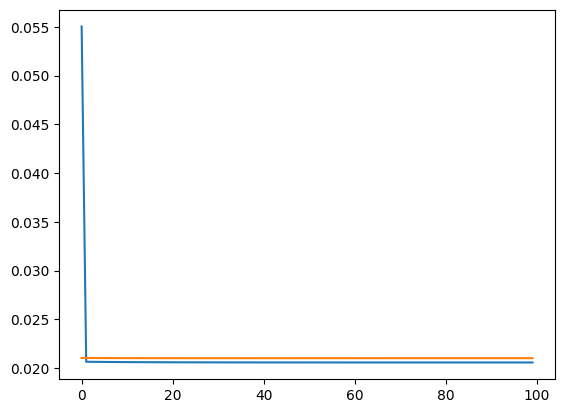

In [16]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

In [17]:
# test split
X_test = X[5000:]
y_test = y[5000:]

# train split
X_train = X[:5000]
y_train = y[:5000]

In [18]:
window_size, hidden_dim, learning_rate, num_epochs = best_params
train_losses, test_losses = train(X_train, y_train, X_test, y_test, window_size, hidden_dim, learning_rate, num_epochs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.76it/s]


In [19]:
print(train_losses[-1])
print(test_losses[-1])

0.02066594484863402
0.020822844244068182


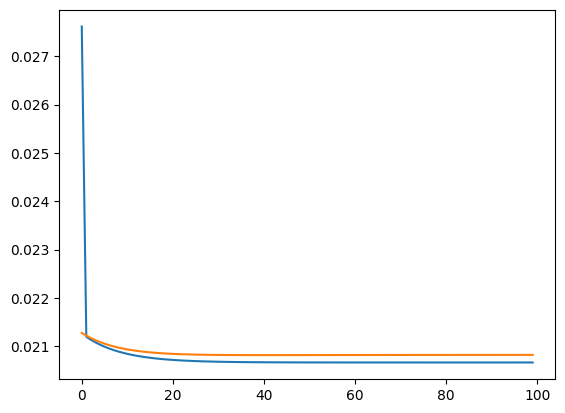

In [20]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()

## RNN

In [21]:
# train split
X_train = X[:4000]
y_train = y[:4000]

# valid split
X_valid = X[4000:5000]
y_valid = y[4000:5000]

In [22]:
grid = {
    "hidden_dim" : [10, 50],
    "learning_rate" : [0.1, 0.3],
    "num_epochs" : [100]
}

train_losses, valid_losses, (hidden_dim, learning_rate, num_epochs) = grid_search_rnn(grid, X_train, y_train, X_valid, y_valid)

  0%|                                                                                                                                                                               | 0/100 [00:00<?, ?it/s]/Users/lucamoroni/Desktop/__WorkSpace/__Universita/unipi/ComputationalNeuroScience/Exs/venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1000, 1, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.10it/s]


 -- finished (10, 0.1, 100) loss 0.021230779588222504


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.08it/s]


 -- finished (10, 0.3, 100) loss 0.021061977371573448


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.95it/s]


 -- finished (50, 0.1, 100) loss 0.021032268181443214


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.89it/s]

 -- finished (50, 0.3, 100) loss 0.02103147655725479
finished grid search, the best are: (50, 0.3, 100)


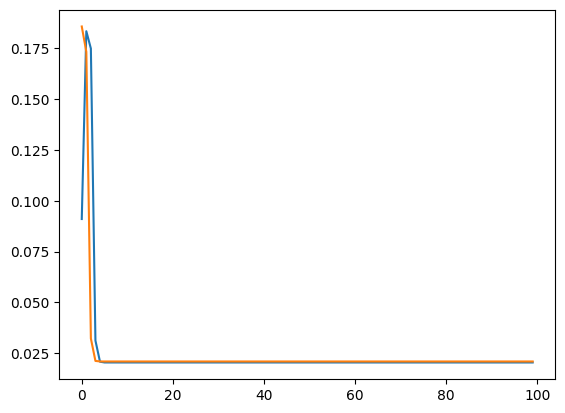

In [23]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

In [24]:
# test split
X_test = X[5000:]
y_test = y[5000:]

# train split
X_train = X[:5000]
y_train = y[:5000]

In [28]:
train_losses, valid_losses = train_rnn(X_train, y_train, X_test, y_test, hidden_dim, learning_rate, num_epochs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.73it/s]


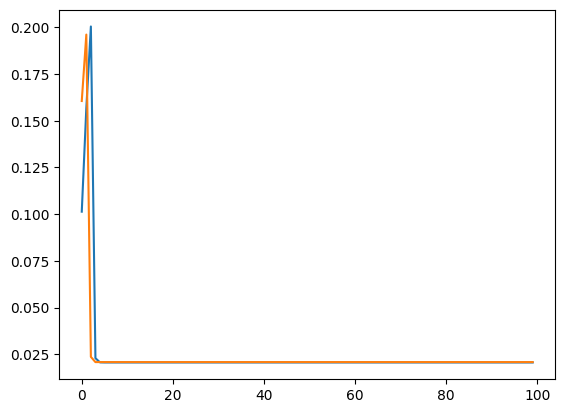

In [31]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

In [32]:
print(train_losses[-1])
print(valid_losses[-1])

0.020623380318284035
0.020833317190408707


In [ ]:
predict_rnn()

# MG17

In [33]:
data_mg17 = pd.read_csv("data/MG17.csv", header=None)

In [34]:
data_mg17.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.032164,0.040426,0.057861,0.084015,0.11544,0.14572,0.16758,0.17624,0.17107,0.15465,...,-0.43905,-0.43957,-0.42772,-0.40213,-0.36305,-0.31286,-0.25555,-0.19556,-0.1368,-0.082192


In [36]:
data = data_narma10.loc[0, :].to_numpy()

X = data[:-1]
y = data[1:]

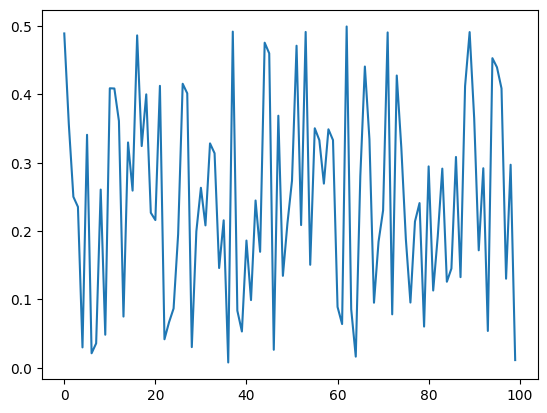

In [37]:
plt.plot(y[:100])
plt.show()

## TDNN

In [38]:
# train split
X_train = X[:4000]
y_train = y[:4000]

# valid split
X_valid = X[4000:5000]
y_valid = y[4000:5000]

In [39]:
grid = {
    "window_size" : [2, 5],
    "hidden_dim" : [30, 50],
    "learning_rate" : [0.01, 0.1],
    "num_epochs" : [100]
}

train_losses, valid_losses, best_params = grid_search(grid, X_train, y_train, X_valid, y_valid)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.86it/s]


 -- finished (2, 30, 0.01, 100) loss 0.0210244421614334


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.89it/s]


 -- finished (2, 30, 0.1, 100) loss 0.022863636957481503


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.64it/s]


 -- finished (2, 50, 0.01, 100) loss 0.021024551591835916


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.06it/s]


 -- finished (2, 50, 0.1, 100) loss 0.02627371298149228


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.27it/s]


 -- finished (5, 30, 0.01, 100) loss 0.021015333011746407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.11it/s]


 -- finished (5, 30, 0.1, 100) loss 0.021826233249157667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.23it/s]


 -- finished (5, 50, 0.01, 100) loss 0.02101713779848069


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.20it/s]

 -- finished (5, 50, 0.1, 100) loss 0.023167533916421235
finished grid search, the best are: (5, 30, 0.01, 100)


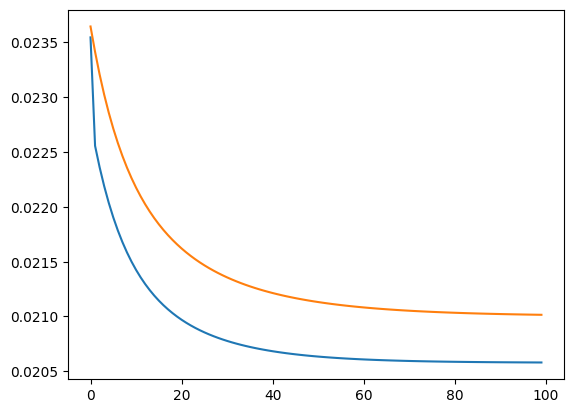

In [40]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

In [41]:
# test split
X_test = X[5000:]
y_test = y[5000:]

# train split
X_train = X[:5000]
y_train = y[:5000]

In [42]:
window_size, hidden_dim, learning_rate, num_epochs = best_params
train_losses, test_losses = train(X_train, y_train, X_test, y_test, window_size, hidden_dim, learning_rate, num_epochs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.34it/s]


In [43]:
print(train_losses[-1])
print(test_losses[-1])

0.02063280560925037
0.020849698730096032


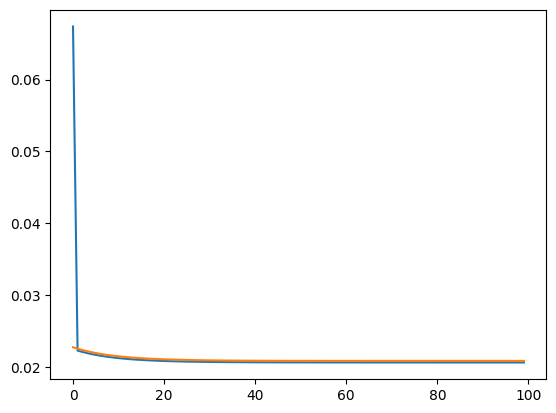

In [44]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()